# Performing Entity Resolution Blocking with Gaussian Mixture Variational Autoencoder - A Experiment

Neste trabalho serão realizados experimentos sobre o uso do modelo Variational Autoencoder com mistura de gaussianas (GMVAE) como uma proposta de metodologia para a etapa de *blocking* do processo de *Entity Resolution* para dados textuais.

## Entity Resolution

A tarefa de Resolução de Entidades refere-se, dado um conjunto de dados, ao problema de encontrar um subconjunto deste que referencie a uma mesma entidade do mundo real. Por exemplo, dado um conjunto de imagens, encontrar quais referem-se à mesma pessoa. Ou dado um conjunto de descrições de produtos, encontrar os que se referem ao mesmo objeto.

O maior desafio dessa técnica surge quando trabalha-se com grandes escalas de dados. Como precisa-se comparar cada par de dados para inferir se eles se tratam ou não da mesma entidade (ou seja, se há um *match*), tem-se um problema de complexidade quadrática: com 1k dados têm-se 1M comparações, etc...

<center>
  <img width="600" src="https://miro.medium.com/max/1400/0*dblW3YQrOo6hHrKP" />
</center>

Para contornar esse obstáculo, antes da etapa de *matching*, busca-se reduzir o espaço de busca utilizando uma estratégia de indexação dos dados, onde a escolha mais comum na esmagadora maioria dos casos é a técnica de *blocking*.



### Blocking

Nesta etapa, procura-se agrupar os dados em blocos de modo a garantir (sempre que possível) que dados de uma mesma entidade permaneçam dentro de um mesmo bloco. Com isso, ao buscar por um *match* de um dado, ao invés de buscar em todo o *dataset* original, isso é feito apenas dentro do respectivo bloco cujo tamanho é consideravelmente menor.

Com isso, existem duas características desejáveis nesse processo:

#### Reachability

Como dito antes, deseja-se que dados de uma mesma entidade concentrem-se dentro de um mesmo bloco, pois, caso contrário, eles estariam espalhados e não seriam alcançados na etapa de *matching*. Para medir o quanto esses dados são "alcançáveis" dentro de um bloco, criou-se a métrica de **Reachability**, apresentada posteriormente.


#### Dispersão

Outra propriedade interessante é a dispersão. Imagine o caso em que a primeira característica foi satisfeita, porém no processo foram utilizados apenas 4 dos 10 blocos disponíveis. Apesar do espaço de busca ter sido reduzido, ele não tornou-se tão menor quanto poderia. É isso que a métrica **Dispersal** mede.

## Variational Autoenconder

<center>
  <img width="750" src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png" />
</center>


## Gaussian Mixture Model

<center>
  <img width="600" src="http://4.bp.blogspot.com/-5Gr6YWHlcpQ/VGt46YCR1oI/AAAAAAAAA1Y/x2lfEKEBBMI/s1600/iter_5.png" />
</center>


## Formulação Matemática

Conjunto de blocos $b \in \{1, ..., B\}$.

Conjunto de dados $r \in \{1, ..., R\}$.

Conjunto de entidades $e \in \{1, ..., E\}$.

$\gamma_r := $ bloco em que o dado $r$ foi alocado.

$\lambda_r := $ entidade relacionada ao dado $r$.

### Matriz de Alocação

Conjunto de dados alocados ao bloco $b$ e relacionados à entidade $e$: $R^b_e = \{ r | \gamma_r = b \land \lambda_r = e\}$

A matriz de alocação é formada da seguinte maneira:

\begin{align}
A_{E \times B} := A_{eb} = |R^b_e|
\end{align}

Ou seja, as linhas são as entidades e as colunas são os blocos.

### Reachability (ou apenas Reachy)

Considere o vetor $\mathbf{a_i}$ formado pela linha $i$ da matriz $A$, o qual representada a alocação dos dados de uma entidade para cada um dos $B$ blocos. Podemos calcular o *reachy* desse vetor como segue:

\begin{align}
Reachy(\mathbf{a_i}) = max(\mathbf{a_i}) \times (\sum_{j = 1}^{B} a_{ij})^{-1}
\end{align}

Para a matriz completa, basta computar a média dos *reachy's* de cada linha.

\begin{align}
Reachy(A) = \frac{1}{n} \sum_{i = 1}^{E} Reachy(\mathbf{a_i})
\end{align}

### Dispersão

Da mesma forma, considere o vetor $\mathbf{a_i}$ formado pela linha $i$ da matriz $A$. Primeiro deveremos criar novos vetores $\mathbf{\alpha_i}$ equivalentes, preenchidos com a proporção dos dados de uma entidade. Isso garante que a quantidade de dados de uma entidade não influencie no resultado:

\begin{align}
\alpha_i = a_i \times (\sum_{j = 1}^{B} a_{ij})^{-1}
\end{align}

Depois disso calculamos o vetor de "erros" $\epsilon$:
\begin{align}
\epsilon = (\sum_{i = 1}^{E} \alpha_{i}) (\sum_{i = 1}^{E} \sum_{j = 1}^{B} \alpha_{ij})^{-1} - \frac{1}{B}
\end{align}

Por fim, calculamos a dispersão:

\begin{align}
Dipersal = 1 - \frac{1}{2}\frac{B}{B - 1}\sum_{i = 1}^{B} \epsilon_{i}
\end{align}

### Exemplo


Considere as matrizes de alocação abaixo, as quais representam o mesmo conjunto de dados com 3 entidades e 69 valores, porém, com diferentes alocações nos 3 blocos disponíveis. Por exemplo, nas alocações da matriz $A_1$, a entidade 1 tem 11 dados no primeiro bloco, 2 no segundo e 5 no terceiro. \

\begin{align}
A_1 = 
\begin{bmatrix}
11 & 2 & 5\\
1 & 20 & 0\\
10 & 9 & 11
\end{bmatrix}
%
A_2 = 
\begin{bmatrix}
16 & 2 & 0\\
20 & 0 & 1\\
30 & 0 & 0
\end{bmatrix}
%
A_3 = 
\begin{bmatrix}
0 & 18 & 0\\
0 & 0 & 21\\
30 & 0 & 0
\end{bmatrix}
\end{align}

Os seus respectivos valores para as métricas Reachability e Dispersal são:

|       | Reachability | Dispersal |
|-------|--------------|-----------|
| $A_1$ |     0.643    |   0.818   |
| $A_2$ |     0.947    |   0.079   |
| $A_3$ |      1.0     |    1.0    |

É importante notar que a matriz $A_3$ alocou todos os dados de cada entidade em um bloco diferente, o que lhe garante um escore máximo em ambas as métricas.



## GMVAE

A ideia de usar a Mistura de Gaussianas como a distribuição a priori para o Variational Autoencoder (VAE) já está presente na literatura tanto com uma abordagem não-supervisionada quanto semi-supervisionada. Este modelo é comumente empregado em problemas de clusterização, pois dado que o número de ;;clusters é discreto e o VAE foi originalmente modelado para variáveis contínuas, a aplicação da Mistura de Gaussianas pode contornar esse problema ao assumir cada moda do espaço latente como uma classe.

## Dataset Wikilinks

Para a análise aqui apresentada e para os futuros trabalhos, foi escolhido o Dataset Wikilinks.

> 40 milhões de menções [à entidades] sem ambiguidade em mais de 10 milhões de páginas da web.

O dataset foi disponibilizado em 2013 e possui duas versões: uma contendo apenas os contextos das menções de cada entidade sobre as páginas exploradas e outra contendo, além disso, o texto completo do artigo e a estrutura do DOM (Document Object Model) dessas páginas. A escolhida aqui foi a primeira.

Esse conjunto escolhido possui em torno de 40 milhões de menções. Mas, por questões de tempo, foi extraído uma amostra de 83 mil menções.

### Exemplo

| wiki\_url                       | full\_context                                      |
|---------------------------------|----------------------------------------------------|
| .../wiki/materialism            | "(with Woolgar), We have Never Been Modern , an... |
| .../wiki/han\_solo              | "Jedi , in which Jabba the Hutt states, ""I wil... |
| .../wiki/tangerine\_dream       | "even on my radar until they released a cover o... |
| .../wiki/romantic\_comedy\_film | "is when I will give it to the label. But I'm n... |
| .../wiki/tragedy                | "many things here that make me think of Greek t... |
| .../wiki/materialism            | "term ""business method""  I'll plead guilty. I... |
| .../wiki/lego                   | "the street from Time square. It is very bright... |
| .../wiki/king                   | "there is a general acceptance amongst modern w... |


## Instalando pacotes

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=89304e262c6ce4f5234fb229d69e8a27927cfdf9c73f37ce3d0c07481128925a
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
# clone the github repository to access source code
!git clone https://github.com/samirbraga/GMVAE.git

# set the correct directory/
%cd GMVAE/pytorch

Cloning into 'GMVAE'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 185 (delta 54), reused 87 (delta 33), pack-reused 73
Receiving objects: 100% (185/185), 62.76 KiB | 2.51 MiB/s, done.
Resolving deltas: 100% (75/75), done.
/content/GMVAE/pytorch


## Bibliotecas usadas

In [ ]:
import numpy as np
import argparse
from collections import Counter
import random
import torch
from torchvision import datasets, transforms
import torch.utils.data as utils_data
from scipy.io import loadmat
from model.GMVAEBlocking import *
from metrics.metrics import blocks_by_entities, blocking_accuracy
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Parâmetros do Modelo

In [ ]:
class Args(dict):
    __slots__ = () 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

In [ ]:
default_args = {
    'seed': 1,

    ## GPU
    'cuda': 0,
    'gpuID': 0,

    ## Training
    'epochs': 100,
    'batch_size': 64,
    'batch_size_val': 200,
    'learning_rate': 1e-3,
    'decay_epoch': -1,
    'lr_decay': 0.5,

    ## Architecture
    'num_classes': 10,
    'gaussian_size': 2,
    'input_size': 512,

    ## Partition parameters
    'train_proportion': 1.0,

    ## Gumbel parameters
    'init_temp': 1.0,
    'decay_temp': 1,
    'hard_gumbel': 0,
    'min_temp': 0.5,
    'decay_temp_rate': 0.013862944,

    ## Loss function parameters
    'w_gauss': 2,
    'w_categ': 0,
    'w_rec': 100,
    'w_blocking': 0,
    'rec_type': 'cosine',

    ## Others
    'verbose': 0
}

In [ ]:
def get_args(**args):
    args_dics = dict(list(default_args.items()) + list(args.items()))
    return Args(args_dics)

## Reproducibilidade

Set random seed in case it was specified in the parameters


In [ ]:
## Random Seed
SEED = default_args['seed']
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
if default_args['cuda']:
  torch.cuda.manual_seed(SEED)

def seed_worker(worker_id):
    numpy.random.seed(SEED)
    random.seed(SEED)

Para o ambiente do colab, somente.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Carregamento dos Dados

In [ ]:
BASE_PATH = '.'

In [ ]:
text_data = pd.read_parquet(BASE_PATH + '/sample_wiki_links-use_emb.parquet')
text_data['full_context_use_emb'] = text_data['full_context_use_emb'].apply(lambda x: x[0]['values'])
target_map = dict([(wiki_url, index) for index, wiki_url in enumerate(text_data['wiki_url'].unique())])
text_data['target'] = text_data['wiki_url'].apply(lambda x: target_map[x])

Separação em treino em teste:

In [ ]:
embeddings = torch.tensor(np.stack(text_data['full_context_use_emb'].values)).float()
entities = torch.tensor(text_data['target'].values.astype(np.int))
emb_train_full, emb_test, ent_train_full, ent_test = train_test_split(embeddings, entities, test_size=0.33, random_state=SEED, stratify=entities)
emb_train, emb_val, ent_train, ent_val = train_test_split(emb_train_full, ent_train_full, test_size=0.2, random_state=SEED, stratify=ent_train_full)

Conversão em tensores do PyTorch:

In [ ]:
train_dataset = utils_data.dataset.TensorDataset(emb_train, ent_train)
full_train_dataset = utils_data.dataset.TensorDataset(emb_train_full, ent_train_full)
val_dataset = utils_data.dataset.TensorDataset(emb_val, ent_val)
test_dataset = utils_data.dataset.TensorDataset(emb_test, ent_test)

Criação dos loaders:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=default_args['batch_size'], worker_init_fn=seed_worker, generator=g)
full_train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=default_args['batch_size'], worker_init_fn=seed_worker, generator=g)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=default_args['batch_size_val'], worker_init_fn=seed_worker, generator=g)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=default_args['batch_size_val'], worker_init_fn=seed_worker, generator=g)

## Otimização Bayesiana

Preparação dos objetos para a otimização:

In [ ]:
def model_loss(**args):
  opt_args = get_args(input_size=512, epochs=100, **args)
  gmvae = GMVAEBlocking(opt_args)
  history_loss = gmvae.train(train_loader, val_loader)
  val_loss, val_rec, val_gauss, val_cat, val_acc, val_disp = gmvae.test(val_loader, True)
  return -val_loss

In [ ]:
pbounds = {
  'learning_rate': (1e-3, 1e-2),
  'lr_decay': (1, 20),
  'decay_temp': (0.5, 2),
  'decay_temp_rate': (0.0013862944, 0.02)
}

optimizer = BayesianOptimization(
    f=model_loss,
    pbounds=pbounds,
    random_state=1,
)

## Treinameto do modelo

### Detalhes do Modelo

Rede de inferência:
```py
# q(y|x)
self.inference_qyx = torch.nn.ModuleList([
    nn.Linear(x_dim, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    GumbelSoftmax(512, y_dim)
])

# q(z|y,x)
self.inference_qzyx = torch.nn.ModuleList([
    nn.Linear(x_dim + y_dim, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    Gaussian(512, z_dim)
])
```

Rede generativa:

```py
# p(z|y)
self.y_mu = nn.Linear(y_dim, z_dim)
self.y_var = nn.Linear(y_dim, z_dim)

# p(x|z)
self.generative_pxz = torch.nn.ModuleList([
    nn.Linear(z_dim, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, x_dim),
    torch.nn.Sigmoid()
])
```

#### Distribuição Gumbel-Softmax

O truque de reparametrização que geralmente é usado para VAEs não pode ser aplicado diretamente a variáveis discretas. Existem algumas alternativas a isso, mas aqui será utilizada a reparametrização de variáveis categóricas por meio da distribuição Gumbel-Softmax. Essa estratégia traz um estimador de gradiente eficiente que substitui a amostra não diferenciável de uma distribuição categórica por uma amostra diferenciável da distribuição Gumbel-Softmax. O autor da implementação usada aqui afirma que, em comparação com outras estratégias, resulta em melhor complexidade de tempo devido ao número reduzido de estimativas de gradiente.

#### Softmax temperature $\tau$

<center>
  <img width="840" src="https://drive.google.com/uc?id=10tqDirE6yjSpO58839nFv8YQ397-QOH4" />
</center>

### Execução

In [ ]:
RETRAIN = False

Utilizando 10 classes:

In [ ]:
num_classes = 10

In [ ]:
if RETRAIN:
  optimizer.maximize(
    init_points=4,
    n_iter=23
  )
  print(f"Melhores parâmetros: {optimizer.max['params']}")
  args = get_args(num_classes=num_classes,
                  input_size=512,
                  epochs=600,
                  **optimizer.max['params'])
  gmvae = GMVAEBlocking(args)
  history_loss = gmvae.train(full_train_loader, val_loader)
  gmvae.save(BASE_PATH + "/best_model")
else:
  args = get_args(num_classes=num_classes,
                  input_size=512,
                  epochs=50,
                  w_rec=100,
                  lr_decay=4,
                  learning_rate=0.001135,
                  decay_temp_rate=0.00443,
                  decay_temp=1.727)
  gmvae = GMVAEBlocking(args)
  history_loss = gmvae.train(full_train_loader, val_loader)

## Avaliação

In [ ]:
train_latent_features, train_entities = gmvae.latent_features(train_loader, True)
train_reachy, train_dispersal, train_blocking = gmvae.test(train_loader)

test_latent_features, test_entities = gmvae.latent_features(test_loader, True)
test_reachy, test_dispersal, test_blocking = gmvae.test(test_loader)

In [ ]:
train_blocks_by_entities = blocks_by_entities(num_classes, torch.Tensor(train_entities).int(), torch.Tensor(train_blocking).int())
test_blocks_by_entities = blocks_by_entities(num_classes, torch.Tensor(test_entities).int(), torch.Tensor(test_blocking).int())
test_accuracy = blocking_accuracy(train_blocks_by_entities, test_blocks_by_entities)

In [ ]:
print(f'Train = (reachy: {train_reachy}, dispersal: {train_dispersal})')
print(f'Test = (reachy: {test_reachy}, dispersal: {test_dispersal}, accuracy: {test_accuracy})')

Train = (reachy: 74.56831359863281, dispersal: 55.555545806884766)
Test = (reachy: 73.94923400878906, dispersal: 55.555545806884766, accuracy: 0.93)


## Visualização dos Espaços Latentes

In [ ]:
def plot_latent_features(latent_features):
    fig = plt.figure(figsize=(10, 6))
    plt.scatter(latent_features[:, 0], latent_features[:, 1], marker='o',
                edgecolor='none', cmap=plt.cm.get_cmap('jet', 100), s = 6)
    plt.grid(False)
    plt.axis('off')

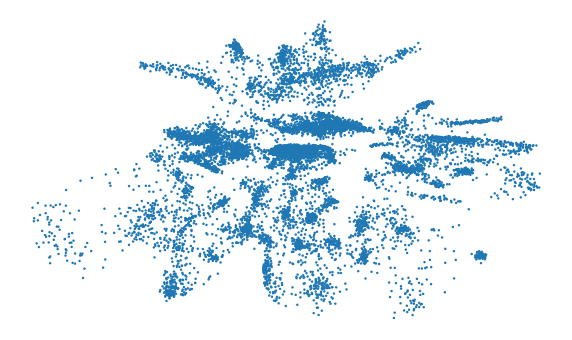

In [ ]:
plot_latent_features(train_latent_features)

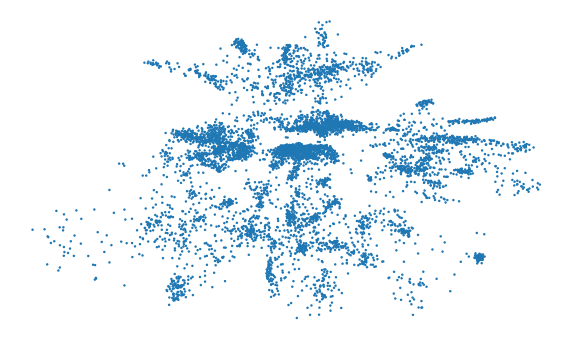

In [ ]:
plot_latent_features(test_latent_features)

## Conclusões:


Considerando que os dados textuais não são, na grande maioria das vezes, bem representativos em relação às entidades que estão relacionados; que, além disso, o modelo de *sentence embedding* utilizado é bem simples quando comparados com o estado da arte atualmente e que, por fim, a dimensão do espaço latente é bem reduzida (apenas bidimensional), acredita-se que os resultados são bem promissores. 

Outros pontos que merecem atenção são:
- A técnica empregada aqui é não-supersionada, o que dispensa a necessidade de rótulos na etapa de *blocking*;
- O modelo é paramétrico, o que traz uma série de benefícios nesse contexto, como a velocidade na predição de novos dados, permitindo uma resolução de entidades dinâmica;
- O modelo é bastante flexível por possuir duas redes responsáveis pela inferência da variável latente e pela geração de novos dados. Logo, a capacidade de lidar com dados complexos pode ser refletida na complexidade dessas redes;
- Mais especificamente sobre os dados textuais, ao invés de utilizar os *sentence embeddings* como entradas do modelo, esse processo já pode estar presente na rede de inferência, utilizando, por exemplo, redes baseadas em *transformers*.